In [2]:
#This code is for the 2nd question of the assessment for the Energy Infrastructure Module at the University of Oxford.
#This code creates the shapefiles used in QGIS to map out the system in comparison to a nearby solar array
#A geo_env kernal should be used to run this code
#The following code was made by the Philippines Team and edited by Canidate 1056380



In [ ]:
# First import all the functions needed
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point 
from shapely.geometry import LineString
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
from shapely.ops import transform

In [4]:
# Start the coordinate transformation process using the initial reference coordinate
# This is the Philippines location point given in assignment, given in Google Earth crs
p0 = Point(10.877639, 123.471833) 

# Create transform function to convert latlong coords into metres for manipulation
project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'), # source coordinate system, GOOGLE EARTH USES 4326 IN DEGREES
    pyproj.Proj('epsg:3395')) # destination coordinate system, MERCATOR IN METRES

# New transformered reference coordinates, used as reference X0 and Y0
pnew  = transform(project.transform, p0)  # apply projection
X0 = pnew.x
Y0 = pnew.y

1210175.351277225

In [3]:
# Dimensions definitions, we need x and y as districts are mapped both vertically and horizontally
# House
x_house= 10 # length of house when travelling 'left-right'
y_house= 10 # length of house when travelling 'up-down'

# Road
x_road=10
y_road=10

# Transformers
length_t=60 # distance from small transformers to central transformer

In [4]:
# Defining initial locations of transformers based on reference point so we can later create loops
transformers=[[X0,Y0],
              [X0+length_t,Y0],
              [X0,Y0+length_t],
              [X0-length_t,Y0],
              [X0,Y0-length_t],
              [X0+length_t,Y0+length_t],
              [X0+-length_t,Y0+length_t]]
trf_df=pd.DataFrame(transformers, columns=["X", "Y"]) # and create a dataframe with coordinates (required for gdf later)

In [5]:
# Function to create all points in a district - this excludes the school
# 4 inputs: entry coordinates, horizontal layout or not, number of houses in district i.e. 48 or 12
# Output is an array of x,y coordinates (no geodata yet, just an array)
def district (x_e,y_e,horizontal,n):
    district=[]
    count=0
    if horizontal==False: # This creates points in the left and right districts
        x=x_e+1/2*x_house
        y=y_e
        while count<(n):
            for i in range (0,12): # We count by sets of 12
                if i<6: 
                     district.append([x+i*x_house,y]) # First set of 6 has same y-coordinates
                else:
                    district.append([x+(i-6)*x_house,y+y_house]) # Second set has y-coords increased by one house dist
            count+=12 # Move into next set of 12, which is separated by additional road distance
            y+=y_road+2*y_house
    if horizontal ==True: # This creates points in the left and right districts
        x=x_e
        y=y_e+1/2*y_house
        while count<(n):
            for i in range (0,12):
                if i<6:
                     district.append([x,y+i*y_house])
                else:
                    district.append([x+x_house,y+(i-6)*y_house])
            count+=12
            x+=x_road+2*x_house
    return district

In [6]:
# Function to create polygons i.e. areas around the points we have just defined - this excludes school
# 2 inputs: the object i.e. district, trf or sch, and half-length or 'radius' around the point
# Output is an array of Polygons, contains geodata
def polygons(df_object, half_length):
    polygons = []
    for i in range (0,len(df_object)):
        X0 = df_object.X[i] # given a reference point
        Y0 = df_object.Y[i]
        X1 = X0-half_length # we create four points around it X1Y1 TO X4Y4
        Y1 = Y0-half_length
        X2 = X0-half_length
        Y2 = Y0+half_length
        X3 = X0+half_length
        Y3 = Y0+half_length
        X4 = X0+half_length
        Y4 = Y0-half_length
        polygons.append(Polygon([(X1, Y1), (X2, Y2), (X3, Y3), (X4, Y4)])) # and create a polygon using those points
        i+=1
    return polygons

In [7]:
# Function to create nodes where distribution lines turn in a district - again, excludes the school
# 4 inputs: district #, horizontal layout or not, initial coordinates of the associated district transformer
# Output is an array of x,y coordinates (no geodata yet, just an array)
def nodes (district,horizontal,x_t,y_t):
    nodes=[]
    nodes.append([x_t,y_t])
    count=6
    n=len(district)
    if n>12:
        if horizontal==False: # Nodes for left-right districts
            nodes.append([x_t,y_t+(y_road+2*y_house)])
            nodes.append([x_t,y_t-(y_road+2*y_house)])
            while count<(n-7):
                x=district[count][0]
                y=district[count][1]+1/2*y_house+1/2*y_road
                for i in range (0,6):
                    nodes.append([x+i*x_house,y])
                count+=24
        if horizontal==True: # Nodes for top-down districts
            nodes.append([x_t+(x_road+2*x_house),y_t])
            nodes.append([x_t-(x_road+2*x_house),y_t])
            while count<(n-7):
                x=district[count][0]+1/2*x_house+1/2*x_road
                y=district[count][1]
                for i in range (0,6):
                    nodes.append([x,y+i*y_house])
                count+=24
    if n==12: # These are the nodes for district 5 i.e. top right outlier of 12
        x=district[0][0]+1/2*x_house
        y=district[0][1]-y_house
        for i in range (0,7):
            nodes.append([x,y+i*y_house])
    return nodes

In [8]:
# Function to create all lines going from transformer to the houses
# 2 inputs: district and nodes #
# Output is an array of LineStrings, has geodata already
def lines(district,nodes):
    n=len(district)
    lines=[]
    if n>12:
        count1=0
        count2=0
        for i in range (0,6):
            lines.append(LineString([[X0,Y0],nodes[0],nodes[2],nodes[3+count1+i],district[i+count2],district[i+12+count2]]))
            lines.append(LineString([[X0,Y0],nodes[0],nodes[2],nodes[3+count1+i],district[i+6+count2],district[i+12+6+count2]]))
        count1+=6
        count2=+24
        for i in range (0,6):
            lines.append(LineString([[X0,Y0],nodes[0],nodes[1],nodes[3+count1+i],district[i+count2],district[i+12+count2]]))
            lines.append(LineString([[X0,Y0],nodes[0],nodes[1],nodes[3+count1+i],district[i+6+count2],district[i+12+6+count2]]))
    else:
        for i in range (0,6):
            lines.append(LineString([[X0,Y0],nodes[0],nodes[1],nodes[2+i],district[i],district[i+6]]))
    return lines

In [9]:
# Defining district points/centroids by applying function; note that transformer dataframes already defined initially
# Inputs: you will need to define the starting point for each district, Horizontal: True/False, and no. houses
district1=district(X0-length_t-1/2*x_road-6*x_house,Y0-y_road-4*y_house,False,48)
district2=district(X0-x_road-4*x_house,Y0-length_t-1/2*y_road-6*y_house,True,48)
district3=district(X0+length_t+1/2*x_road,Y0-y_road-4*y_house,False,48)
district4=district(X0-x_road-4*x_house,Y0+length_t+1/2*y_road,True,48)
district5=district(X0+length_t+1/2*x_road,Y0+length_t+1/2*y_road,True,8)
# We directly define the school's coordinates, with reference to ref point X0Y0
districtsch = {'X': [X0-11*x_house], 'Y': [Y0+11*y_house]}

# With the output arrays, we now create dataframes for each district
d1 = pd.DataFrame(district1, columns=["X", "Y"])
d2 = pd.DataFrame(district2, columns=["X", "Y"])
d3 = pd.DataFrame(district3, columns=["X", "Y"])
d4 = pd.DataFrame(district4, columns=["X", "Y"])
d5 = pd.DataFrame(district5, columns=["X", "Y"])
# Again, school dataframe is directly defined
dsch = pd.DataFrame(data=districtsch)

# Combining all dataframes into one array with all district points and transformer points
d = [trf_df, d1, d2, d3, d4, d5, dsch]
# Making into a big dataframe that contains points of trf + houses + school
df_d = pd.concat(d)

# Making into a geodataframe of points
gdf_d= gpd.GeoDataFrame(df_d, geometry=gpd.points_from_xy(df_d.X, df_d.Y))

# Can print to test, should give 213 points/rows
#print(gdf_d)

In [89]:
# running the polygons function by district, and transformers
polygons_district1=polygons(d1,5) # you can set your own 'size' of house using second variable, here 10m by 10m
polygons_district2=polygons(d2,5)
polygons_district3=polygons(d3,5)
polygons_district4=polygons(d4,5)
polygons_district5=polygons(d5,5)
polygons_trf=polygons(trf_df,1) # here size of transformer is 2m by 2m
polygons_sch=polygons(dsch,50) # and school is 100m by 100m

# Combining all dataframes into one array with all district polygons and transformer polygons
df_poly_d1 = pd.DataFrame({'geometry': polygons_district1})
df_poly_d2 = pd.DataFrame({'geometry': polygons_district2})
df_poly_d3 = pd.DataFrame({'geometry': polygons_district3})
df_poly_d4 = pd.DataFrame({'geometry': polygons_district4})
df_poly_d5 = pd.DataFrame({'geometry': polygons_district5})
df_poly_trf = pd.DataFrame({'geometry': polygons_trf})
df_poly_sch = pd.DataFrame({'geometry': polygons_sch})
# Making into a big dataframe that contains polygons of trf + houses + school
d_polygons = [df_poly_d1, df_poly_d2, df_poly_d3, df_poly_d4, df_poly_d5, df_poly_trf, df_poly_sch]
df_polygons = pd.concat(d_polygons)

# Making into a geodataframe of polygons
gdf_polygons= gpd.GeoDataFrame(df_polygons)

In [90]:
# Defining node points/centroids where lines turn by applying function
# You will need to input which district, as well as the transformer position x_t and y_t
nodes1=nodes(district1,False,X0-length_t,Y0) # NOTE TO SELF MAYBE AUTOMATE THIS
nodes2=nodes(district2,True,X0,Y0-length_t)
nodes3=nodes(district3,False,X0+length_t,Y0)
nodes4=nodes(district4,True,X0,Y0+length_t)
nodes5=nodes(district5,True,X0+length_t,Y0+length_t)

# Defining lines by applying function
# You will need to define which district and nodes it runs through
lines1=lines(district1,nodes1)
lines2=lines(district2,nodes2)
lines3=lines(district3,nodes3)
lines4=lines(district4,nodes4)
lines5=lines(district5,nodes5)
# Create school line array separately, note it doesn't need to go through a node (trf direct to school)
linessch=[]
linessch.append(LineString([(X0,Y0),transformers[6],(X0-11*x_house, Y0+11*y_house)]))

# To create a geodataframe for lines, first we need both the line names and the line geometry i.e. LineString
# Defining the list containing all LineString data
list_lines=lines1+lines2+lines3+lines4+lines5+linessch
# Defining the line numbers
line_number=[0]*len(list_lines)
# And create names for them
names_lines=[0]*(len(list_lines))
for i in range (len(list_lines)):
    names_lines[i]='Line %s'%i

# Now, create geodataframe containing lines' geometries
l = {'col1': names_lines, 'geometry': list_lines}
gdf_lines = gpd.GeoDataFrame(l)

<AxesSubplot:>

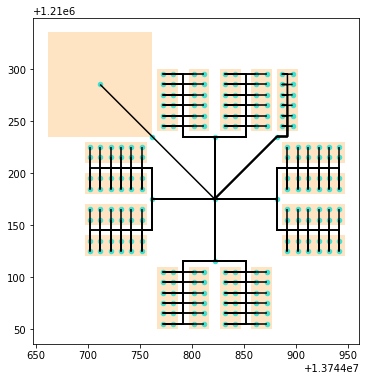

In [91]:
# This should give you a plot of (1) Polygons (2) Lines and (3) Points of all transformers, houses, school
gdf_d.plot(ax=gdf_lines.plot(ax=gdf_polygons.plot(figsize=(10, 6), color= 'bisque'), color='black'), marker='o', color='turquoise', markersize=20)

In [92]:
# Now, we need to convert all the coordinates into latlong CRS for OpenStreetMap
# Note we will be using OSM as the base layer in QGIS, I'm not sure if you use a different base map if you'll need to find/change to the respective CRS

# Create transform to new coordinate system (OSM uses 3857)
project2 = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:3395'), # source coordinate system, MERCATOR IN METRES
    pyproj.Proj('epsg:3857')) # destination coordinate system, OPENSTREETMAP IN DEGREES

In [93]:
# To create transformations, we need to run a list of all the points/lines/polygons through the transformation function
# Create list of points
list_point=gpd.points_from_xy(df_d.X, df_d.Y)

# Create list of polygons
list_polygons=polygons_district1+polygons_district2+polygons_district3+polygons_district4+polygons_district5+polygons_trf+polygons_sch

# Note we already have a list of lines defined above (list_lines)

In [94]:
# Create empty arrays for each respective point/line/polygon to store the transformed coordinates

#Change the points coordinates by applying the above transformation function
n1=len(list_point)
points_qgis=[]
for i in range (n1):
    points_qgis.append(transform(project2.transform,list_point[i]))

#Change the line coordinates
n2=len(list_lines)
lines_qgis=[]
for i in range (n2):
    lines_qgis.append(transform(project2.transform,list_lines[i]))
    
# Change the polygon coordinates
n3=len(list_polygons)
polygons_qgis=[]
for i in range (n3):
    polygons_qgis.append(transform(project2.transform,list_polygons[i]))

In [95]:
# Now we first save each list as a geodataframe, then save as a .shp file
# Points

# And now create geodataframe using list of all points
points_epsg = {'geometry': points_qgis}
gdf = gpd.GeoDataFrame(points_epsg, crs="EPSG:3857")
print(gdf)

# Lines
lines_epsg = {'geometry': lines_qgis}
gdf2 = gpd.GeoDataFrame(lines_epsg, crs="EPSG:3857")
print(gdf2)

# Polygons
polygons_epsg = {'geometry': polygons_qgis}
gdf3 = gpd.GeoDataFrame(polygons_epsg, crs="EPSG:3857")
print(gdf3)



                             geometry
0    POINT (13744821.577 1218233.563)
1    POINT (13744881.577 1218233.563)
2    POINT (13744821.577 1218293.953)
3    POINT (13744761.577 1218233.563)
4    POINT (13744821.577 1218173.173)
..                                ...
207  POINT (13744896.577 1218324.148)
208  POINT (13744896.577 1218334.213)
209  POINT (13744896.577 1218344.278)
210  POINT (13744896.577 1218354.343)
211  POINT (13744711.577 1218344.278)

[212 rows x 1 columns]
                                              geometry
0    LINESTRING (13744821.577 1218233.563, 13744761...
1    LINESTRING (13744821.577 1218233.563, 13744761...
2    LINESTRING (13744821.577 1218233.563, 13744761...
3    LINESTRING (13744821.577 1218233.563, 13744761...
4    LINESTRING (13744821.577 1218233.563, 13744761...
..                                                 ...
98   LINESTRING (13744821.577 1218233.563, 13744881...
99   LINESTRING (13744821.577 1218233.563, 13744881...
100  LINESTRING (13744821

In [96]:
# We add in Cadiz details - point, polygon, line to central transformer
# Cadiz point, transform twice from Google Earth CRS to Mercator, to OSM CRS
cadiz_old = Point(10.934859070907093, 123.28718432607502) 
cadiz_new = transform(project.transform, cadiz_old)
cadiz_qgis = []
cadiz_qgis.append(transform(project2.transform,cadiz_new))
cadiz_epsg = {'geometry': cadiz_qgis}
gdf_cadiz = gpd.GeoDataFrame(cadiz_epsg, crs="EPSG:3857")
print(gdf_cadiz)

# Cadiz line, from central transformer to Cadiz point, transform once from Mercator to OSM CRS
cadiz_line = LineString([(list_point[0]), cadiz_new])
cadiz_line_qgis = []
cadiz_line_qgis.append(transform(project2.transform,cadiz_line)) # line from central transformer to cadiz generator
cadiz_line_epsg = {'geometry': cadiz_line_qgis}
gdf_cadiz_line = gpd.GeoDataFrame(cadiz_line_epsg, crs="EPSG:3857")
print(gdf_cadiz_line)

# Cadiz polygon, using polygon function around central point
x_C = cadiz_new.x
y_C = cadiz_new.y
cadiz_poly_df = pd.DataFrame({'X': [x_C], 'Y': [y_C]})
cadiz_polygon = polygons(cadiz_poly_df,100) # from Google maps Cadiz is roughly 200m by 200m

cadiz_poly_qgis = []
points_qgis=[]
for i in range (1):
    cadiz_poly_qgis.append(transform(project2.transform,cadiz_polygon[i]))

# Then transforming once from Mercator to OSM CRS
cadiz_poly_epsg = {'geometry': cadiz_poly_qgis}
gdf_cadiz_poly = gpd.GeoDataFrame(cadiz_poly_epsg, crs="EPSG:3857")
print(gdf_cadiz_poly)

                           geometry
0  POINT (13724266.581 1224720.438)
                                            geometry
0  LINESTRING (13744821.577 1218233.563, 13724266...
                                            geometry
0  POLYGON ((13724166.581 1224619.788, 13724166.5...


In [97]:
#Saving the .shp file, note this will save to the same destination folder where this code is stored
gdf.to_file("points.shp")
gdf2.to_file("lines.shp")
gdf3.to_file("polygons.shp")
gdf_cadiz.to_file("cadiz_point.shp")
gdf_cadiz_line.to_file("cadiz_line.shp")
gdf_cadiz_poly.to_file("cadiz_poly.shp")

# You should now be able to open QGIS and load each .shp layer onto the map
# Use OSM as base layer and it should be located on the Philippines site, 'zoom to layer' on the points layer to see Cadiz site